In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bz2
from nltk.tokenize import word_tokenize
import string
from sklearn.utils import shuffle
import random

/home/sandipan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#extracting data
trainFile='test.ft.txt.bz2'
file=bz2.BZ2File(trainFile,'r')
lines=file.readlines()
listOfsentiments = []

In [3]:
def getallSentiments(docs,splitStr='__label__'):
    for i in range(len(docs)):
        #print('Processing line ',i+1,' of ',len(docs))
        text=str(lines[i])
        #print(text)
        splitText=text.split(splitStr)
        actual=splitText[1]
        text=actual[2:len(actual)-3]
        sentiment=actual[0]
        # if i<5:
            #print('First half:',actual[0],'\nsecond half:',actual[2:len(actual)-3])
        listOfsentiments.append([text,sentiment])
    print('Done!!')
    return listOfsentiments

In [4]:
listOfsentiments=getallSentiments(lines[:1000000],splitStr='__label__')

Done!!


In [5]:
# tr = str.maketrans("", "", string.punctuation)
# for i in range(len(listOfsentiments)):
#     s = listOfsentiments[i][0] # Sample string 
#     listOfsentiments[i][0] = s.translate(tr)
#     if i<5:
#         print(listOfsentiments[i][0])
#     print("Completed line"+str(i+1))
import re
for i in range(len(listOfsentiments)):

    listOfsentiments[i][0] = re.sub(r'[^\w\s]','',listOfsentiments[i][0])
    # if i<5:
        #print(listOfsentiments[i][0])
    ##print("Completed line"+str(i+1))

In [6]:
df=pd.DataFrame(listOfsentiments,columns=['Review_Text','Sentiment_class_label']) #format: text <label>
revcount = df.shape[0]
rev = df["Review_Text"]
label = df["Sentiment_class_label"]
df.shape

(400000, 2)

In [7]:
# sw = set(stopwords.words('english'))
punc_removed = []
dwords=[]
wcount=[]
for i in range(revcount):
    word_tokens = word_tokenize(rev[i])
    word_tokens = [word.lower() for word in word_tokens]
    if len(word_tokens)<=25:
        for neww in word_tokens:  
            if neww not in dwords:
                dwords.append(neww)
                wcount.append(1)
            else:
                ind = dwords.index(neww)
                wcount[ind] = wcount[ind]+1
                
        punc_removed.append((word_tokens,label[i],i, len(word_tokens)))
    
    
    #print("Completed line"+str(i+1))

In [8]:
# keep = []
# for i in range(len(punc_removed)):
#     keep.append(punc_removed[i][1])
    

# df2 = df[df.index.isin(keep)]

df1 = pd.DataFrame(punc_removed,columns=['tokens','sentiments','ind', 'sen_length'])
final_labels = df1['sentiments']
v = pd.DataFrame({'dwords': dwords,'wcount': wcount})
vocab = v[(v.wcount>5)]
df1.head(5)



,tokens,sentiments,ind,sen_length
0,"[long, and, boring, ive, read, this, book, wit...",1,20,19
1,"[amazing, love, itvery, touchits, to, bad, tha...",2,44,15
2,"[no, another, grill, like, this, this, grill, ...",2,55,24
3,"[creepy, the, creepiest, book, ive, ever, read...",2,88,22
4,"[possibly, the, funniest, movie, ever, made, i...",2,99,22


In [9]:
#creating dictionary
vocab2id = {"<PAD>":0, "<_UNK>":1}
start_id = 2
for i in range(vocab.shape[0]):
    vocab2id[vocab.iloc[i][0]] = start_id
    start_id = start_id+1
    
#inverted dictionary
id2vocab = {value: key for key, value in vocab2id.items()}
# for key, val in id2vocab.items():
#     print(str(key)+"==>"+str(val))


In [22]:
len(vocab2id)

5592

In [11]:
#get embeddings from glove
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# for key, val in embeddings_index.items():
#     #print(str(key)+"==>"+str(val))

In [12]:
embedding_list = np.zeros((len(vocab2id),100))
for key, val in vocab2id.items():
    if key in embeddings_index:
        embedding_list[val] = embeddings_index[key]
    else:
        random_list = []
        for _ in range(100):
            value = random.uniform(-0.5,0.5)
            random_list.append(value)
        random_list = np.asarray(random_list, dtype='float32')
        embedding_list[val] = random_list        


In [13]:
processed_sentences = []
for i in range(df1.shape[0]):
    word2id_vector = np.zeros(25)
    for j in range(df1['sen_length'][i]):
        word = df1.iloc[i][0][j]
        if word not in vocab2id:     
            word2id_vector[j] = vocab2id['<_UNK>']     #only the words having word count >5 have been kept in vocab.
        else:                                               #If it is not in vocab, give it id of 'unknown', i.e.<_UNK>
            word2id_vector[j] = vocab2id[word]
    processed_sentences.append(word2id_vector)
        

In [15]:
processed_sentences = np.asarray(processed_sentences)
print(processed_sentences[1])
final_labels=final_labels.astype('int32')

labels = np.array(final_labels)
for i in range(len(labels)):
    if labels[i]==2:
        labels[i]=0

labels = labels[:,None] #from rank-1 array to 2d array

[19. 20. 21.  1. 22. 23. 24. 25. 18. 26. 27. 28. 29. 30. 31.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


In [23]:
processed_sentences.shape

(26285, 25)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Activation
from keras.layers.embeddings import Embedding

In [17]:
def plotacc(histobj):
    
    # plot accuracy
    plt.plot(histobj.history['acc'])
    plt.plot(histobj.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Accuracy of the model.png')
    plt.show()
    
    # plot loss
    plt.plot(histobj.history['loss'])
    plt.plot(histobj.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Model loss.png')
    plt.show()

In [19]:
#LSTM model
model1 = Sequential()
model1.add(Embedding(len(vocab2id), 100, input_length=25, weights=[embedding_list],trainable = False))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history1 = model1.fit(processed_sentences, np.array(labels), validation_split=0.1, epochs = 10, batch_size = 64)

Train on 23656 samples, validate on 2629 samples
Epoch 1/10
23656/23656 [==============================] - 17s 725us/step - loss: 0.3959 - acc: 0.8161 - val_loss: 0.3343 - val_acc: 0.8650
Epoch 2/10
23656/23656 [==============================] - 14s 612us/step - loss: 0.2794 - acc: 0.8862 - val_loss: 0.2443 - val_acc: 0.9060
Epoch 3/10
23656/23656 [==============================] - 14s 611us/step - loss: 0.2453 - acc: 0.9014 - val_loss: 0.2485 - val_acc: 0.8977
Epoch 4/10
23656/23656 [==============================] - 15s 624us/step - loss: 0.2242 - acc: 0.9107 - val_loss: 0.2222 - val_acc: 0.9152
Epoch 5/10
23656/23656 [==============================] - 15s 617us/step - loss: 0.2033 - acc: 0.9210 - val_loss: 0.2086 - val_acc: 0.9254
Epoch 6/10
23656/23656 [==============================] - 16s 662us/step - loss: 0.1887 - acc: 0.9263 - val_loss: 0.2258 - val_acc: 0.9072
Epoch 7/10
23656/23656 [==============================] - 15s 636us/step - loss: 0.1748 - acc: 0.9324 - val_loss: 0.2

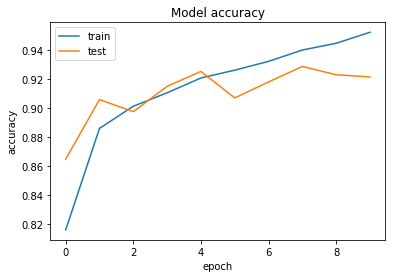

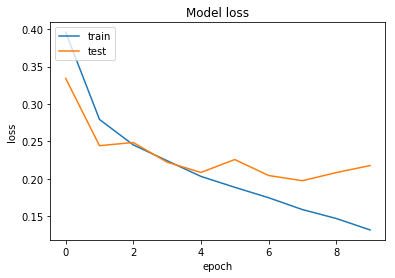

In [20]:
plotacc(history1)